Import Libraries

In [53]:
import os
import numpy as np
import netCDF4 as nc
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

In [54]:
#The following cell is to understand the variable name used in the .nc file

#function to load data from .nc files
def load_nc_data(file_path):
    dataset = nc.Dataset(file_path)
    
    # Check available variable names in the dataset
    print(dataset.variables.keys())
    
    # Return dataset variables
    return dataset

# Load dataset
file_path = '/Users/chiraggurumurthy/D7046E/Project/Dataset/April/T34UFA_20200401T093029_tile_3_9.nc'
dataset = load_nc_data(file_path)

dict_keys(['TCI_R', 'TCI_G', 'TCI_B', 'B04', 'B03', 'B02', 'B08', 'B05', 'B8A', 'B06', 'B11', 'B12', 'B09', 'B10', 'B01', 'Label', 'B07'])


Image shape: (512, 512, 3)
Mask shape: (512, 512)


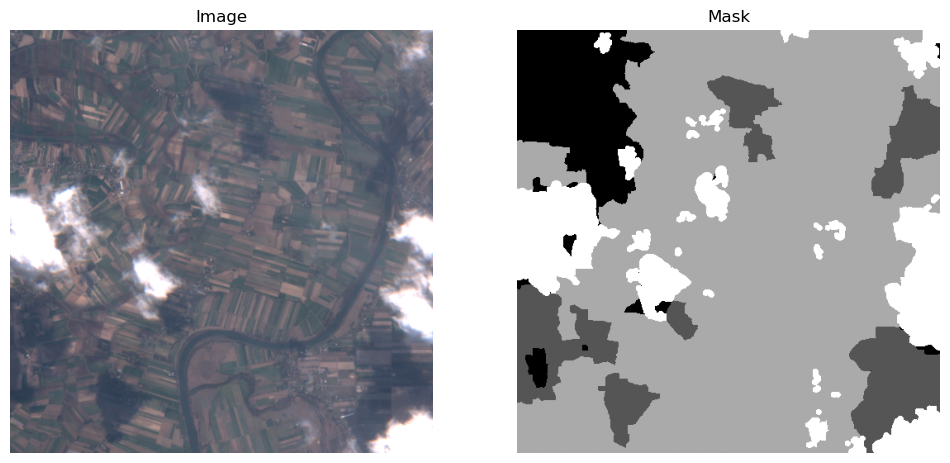

In [55]:
#This cell is to understand the properties of one .nc file in the folder 

# List of expected variables
expected_variables = ['TCI_R', 'TCI_G', 'TCI_B', 'B04', 'B03', 'B02', 'B08', 'B05', 'B8A', 
                      'B06', 'B11', 'B12', 'B09', 'B10', 'B01', 'Label', 'B07']

# function to load data from .nc files
def load_nc_data(file_path):
    dataset = nc.Dataset(file_path)

    #print(f'{dataset.variables}')
    
    # Check for missing variables
    missing_vars = []
    for var in expected_variables:
        if var not in dataset.variables:
            missing_vars.append(var)
    
    # If any variables are missing, print a message or log the missing variables
    if missing_vars:
        print(f"Warning: Missing variables in {file_path}: {', '.join(missing_vars)}")
        return None, None  # Return None for both image and mask if data is incomplete
    
    # Load the different bands and labels
    tci_r = dataset.variables['TCI_R'][:]  # Red band
    tci_g = dataset.variables['TCI_G'][:]  # Green band
    tci_b = dataset.variables['TCI_B'][:]  # Blue band
    mask = dataset.variables['Label'][:]  # Mask data
    
    # Combine the RGB bands to form the image
    image = np.stack((tci_r, tci_g, tci_b), axis=-1)
    
    return image, mask

# Load dataset
file_path = '/Users/chiraggurumurthy/D7046E/Project/Dataset/April/T34UFA_20200401T093029_tile_3_9.nc'
image, mask = load_nc_data(file_path)

print(f'Image shape: {image.shape}')
print(f'Mask shape: {mask.shape}')

# Function to plot images and masks
def plot_sample(image, mask):
    plt.figure(figsize=(12, 6))
    
    # Plot image (color composite)
    plt.subplot(1, 2, 1)
    plt.imshow(image)  # image[index] will correctly slice (512, 512, 3)
    plt.title('Image')
    plt.axis('off')  # Hide axes for a clean view
    
    # Plot mask (binary)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')  # mask[index] will correctly slice (512, 512)
    plt.title('Mask')
    plt.axis('off')  # Hide axes for a clean view
    
    plt.show()

# Plot the first sample
plot_sample(image, mask)

Total number of images loaded: 89
Total number of masks loaded: 89


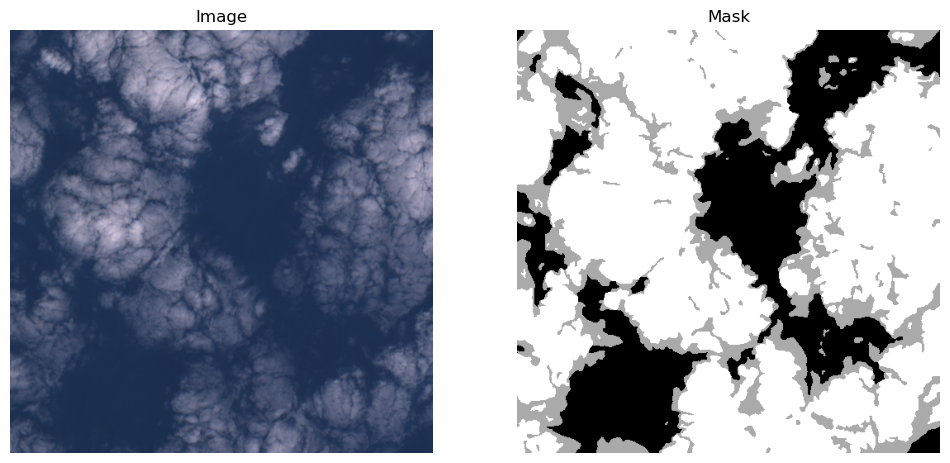

In [56]:
#This cell will load all images into two numpy arrays 

# Function to plot images and masks
def plot_sample(image, mask, index=0):
    plt.figure(figsize=(12, 6))
    
    # Plot image (color composite)
    plt.subplot(1, 2, 1)
    plt.imshow(image[index])  # image[index] will correctly slice (512, 512, 3)
    plt.title('Image')
    plt.axis('off')  # Hide axes for a clean view
    
    # Plot mask (binary)
    plt.subplot(1, 2, 2)
    plt.imshow(mask[index], cmap='gray')  # mask[index] will correctly slice (512, 512)
    plt.title('Mask')
    plt.axis('off')  # Hide axes for a clean view
    
    plt.show()

# A function to iterate over all the .nc files in from each folders 
def load_data_from_folders(base_folder):
    images = []
    masks = []
    
    month_names = ["January", "February", "March", "April", "May", "June", 
                    "July", "August", "September", "October", "November", "December"]

    for month_name in month_names:
     # Construct the folder path for each month
        month_folder = os.path.join(base_folder, month_name)
    
        if os.path.exists(month_folder):
            # Loop through all .nc files in the folder
            for filename in os.listdir(month_folder):
                if filename.endswith('.nc'):
                    file_path = os.path.join(month_folder, filename)
                    #print(f"Processing file: {file_path}")
                    
                    # Load images and masks from the .nc file
                    image, mask = load_nc_data(file_path)
                    images.append(image)
                    masks.append(mask)
                    
    #convert lists to numopy arrays
    images_array = np.array(images)
    masks_array = np.array(masks)

    return images_array, masks_array
                    
# Define the base folder that contains the months (January to December)
base_folder = '/Users/chiraggurumurthy/D7046E/Project/Dataset'

# Process images from all folders
images, masks = load_data_from_folders(base_folder)

# Check if images and masks have been loaded correctly
print(f"Total number of images loaded: {len(images)}")
print(f"Total number of masks loaded: {len(masks)}")

# Plot the first image and mask from the file
plot_sample(images, masks, index=4)

The following cell is for pre-processing the data

In [57]:
# Normalize the images (scale pixel values from [0, 255] to [0, 1])
images = images / 255.0

print(f'Image shape: {images.shape}')

# This step is to check if we are dealing with binary mask or multi-class mask
unique_values = np.unique(masks)
print(f"Unique values in the mask: {unique_values}")

# One-hot encode the masks to have shape (num_samples, 512, 512, num_classes)
num_classes = len(unique_values) 
masks = to_categorical(masks, num_classes=num_classes)

# Check the shape of the masks now (should be [num_samples, 512, 512, num_classes])
print(f"Shape of one-hot encoded masks: {masks.shape}")

Image shape: (89, 512, 512, 3)
Unique values in the mask: [0 1 2 3 4 5]
Shape of one-hot encoded masks: (89, 512, 512, 6)


The following cell is for splitting the data into training, validation, and test sets

In [58]:
# Split the data into training (80%) and test (20%) sets
images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Split the training data into training (80%) and validation (20%) sets
images_train, images_val, masks_train, masks_val = train_test_split(images_train, masks_train, test_size=0.2, random_state=42)

# Check the shapes of the splits
print(f"Training images shape: {images_train.shape}")
print(f"Validation images shape: {images_val.shape}")
print(f"Test images shape: {images_test.shape}")

Training images shape: (56, 512, 512, 3)
Validation images shape: (15, 512, 512, 3)
Test images shape: (18, 512, 512, 3)


Next cell is to build the model

In [59]:
def build_unet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder (downsampling)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Decoder (upsampling)
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    
    x = layers.Conv2DTranspose(num_classes, (3, 3), strides=(2, 2), padding='same')(x)

    # Output layer with softmax activation for multi-class segmentation
    outputs = layers.Softmax()(x)
    
    model = models.Model(inputs, outputs)
    return model

# Define model parameters
input_shape = (512, 512, 3)  # Image shape
num_classes = 6  # Number of classes in your mask

# Build the U-Net model
model = build_unet(input_shape, num_classes)

# Compile the model with appropriate loss and metrics for segmentation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


NameError: name 'layers' is not defined